
 Honours Project - MHW225671  
 Name: Giacomo Fadda  
 Student ID: S2219926  
 Programme of Study: BSc Computing


In [1]:
import tensorflow as tf
import keras
from keras import layers
import os
import pathlib
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import matplotlib.colors as mcolors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import callbacks, optimizers

In [2]:
tf.__version__

'2.15.0'

In [3]:
# check if the system recognise the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


#### import dataset

In [4]:
ds_dir = os.listdir('D:/Honours Project/Dataset/Plant_leave_diseases_dataset/')
for filenames in ds_dir:
    print(filenames)

Background_without_leaves
Apple___Cedar_apple_rust
Apple___Apple_scab
Apple___Black_rot
Apple___healthy
Grape___Black_rot
Grape___Esca_(Black_Measles)
Grape___healthy
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)


In [5]:
dataset_dir = pathlib.Path('D:/Honours Project/Dataset/Plant_leave_diseases_dataset/')
print(dataset_dir)

D:\Honours Project\Dataset\Plant_leave_diseases_dataset


#### Data preprocessing

In [6]:
Image_Size = 180
Batch_Size = 16
Channels = 3

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir, 
    batch_size = Batch_Size, 
    image_size = (Image_Size, Image_Size), 
    shuffle = True,   
    ) 

Found 16867 files belonging to 9 classes.


In [7]:
#Folders(classes) in 'Dataset' directory
class_names = dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy']

In [8]:
print(len(dataset))

# print dataset info
print(dataset)

1055
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
# dividing the dataset into training, validation, and testing
def split_dataset(dataset, train_split=0.8, val_split=0.10, test_split=0.10, shuffle=True, shuffle_size=1000):
    if train_split + val_split + test_split != 1:
        raise ValueError("The sum of train_split, val_split, and test_split must be 1.")
    
    ds_size = tf.data.experimental.cardinality(dataset).numpy()
    if ds_size == -1:
        raise ValueError("Dataset size is unknown. Make sure ds is a finite dataset.")


    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=123)
   
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)  # Correctly skips to take the remainder of the dataset for the test set
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [11]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), 
                                                                                                                                                        len(train_ds), 
                                                                                                                                                        len(val_ds), 
                                                                                                                                                        len(test_ds)))

Size of Data is :1055 
Batch size of Training Data is :844
Batch size of Validation Data is :105 
Batch size of Testing Data is :106 


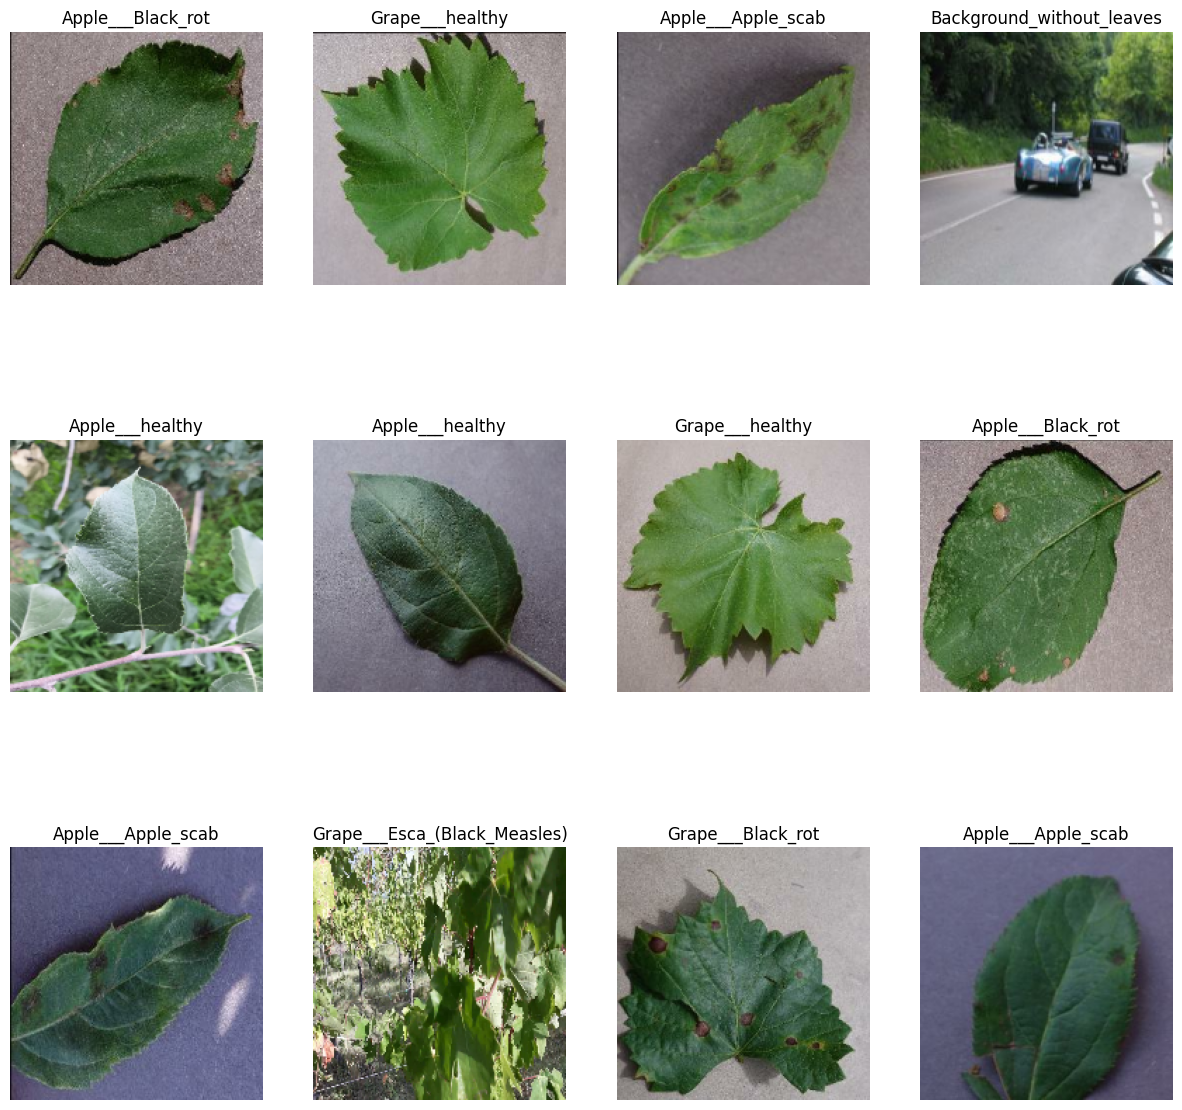

In [12]:
# Plotting the image
plt.figure(figsize = (15,15))
# dataset.take(count) : Creates a Dataset with at most 'count' elements(batch) from the dataset
for image, label in dataset.take(1): 
    for i in range(min(12, len(image))):
        plt.subplot(3, 4, i+1) # many plots at a time =>subpots
        plt.imshow(image[i].numpy().astype('uint8')) #converting all data of image into numpy and than to intiger type as they were in float.
        plt.title(class_names[label[i]])  # title of the class_name of image
        plt.axis("off") # Hide the values of graph

In [13]:
# Processing the data
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Model Structuring and training

In [14]:
num_classes = len(class_names)  # Assuming 'class_names' is defined elsewhere

model = models.Sequential([
    layers.Input(shape=(180, 180, 3)),
    layers.Rescaling(1./255), 
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # layers.Dropout(0.2),  # Maintain dropout for regularization
    layers.Dense(num_classes, activation='softmax')
])

# Define initial hyperparameters
initial_learning_rate = 0.001
epochs = 100

# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch >= 10 and epoch < 20:
        return lr * tf.math.exp(-0.1)
    else:
        return lr * tf.math.exp(-0.2)
    
# Define early stopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    min_delta=1e-3,
    verbose=1,
)

# Compiled the model with the specified initial learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=initial_learning_rate),
    # Adjusted to match your original loss
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  
    metrics=['accuracy']
)

# Explicitly build the model with a batch size of None, which allows for variable batch sizes
model.build((None, 180, 180, 3))

# Display the model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 64800)            

In [15]:
# Train the model with early stopping and learning rate scheduler callbacks
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs, 
    callbacks=[early_stopping, callbacks.LearningRateScheduler(scheduler)]
)

Epoch 1/100


844/844 [==============================] - 132s 123ms/step - loss: 0.5420 - accuracy: 0.8142 - val_loss: 0.2315 - val_accuracy: 0.9238 - lr: 0.0010
Epoch 2/100
844/844 [==============================] - 90s 107ms/step - loss: 0.1729 - accuracy: 0.9396 - val_loss: 0.1194 - val_accuracy: 0.9577 - lr: 0.0010
Epoch 3/100
844/844 [==============================] - 88s 105ms/step - loss: 0.1045 - accuracy: 0.9641 - val_loss: 0.1107 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 4/100
844/844 [==============================] - 83s 98ms/step - loss: 0.0899 - accuracy: 0.9692 - val_loss: 0.1275 - val_accuracy: 0.9494 - lr: 0.0010
Epoch 5/100
844/844 [==============================] - 83s 98ms/step - loss: 0.0579 - accuracy: 0.9802 - val_loss: 0.0348 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 6/100
844/844 [==============================] - 84s 100ms/step - loss: 0.0457 - accuracy: 0.9865 - val_loss: 0.1997 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 7/100
844/844 [========================

In [16]:
# Evaluate the model's accuracy
test_loss, test_acc = model.evaluate(test_ds)

print('Test accuracy:', test_acc)

106/106 [==============================] - 14s 14ms/step - loss: 0.0471 - accuracy: 0.9917
Test accuracy: 0.9917452931404114


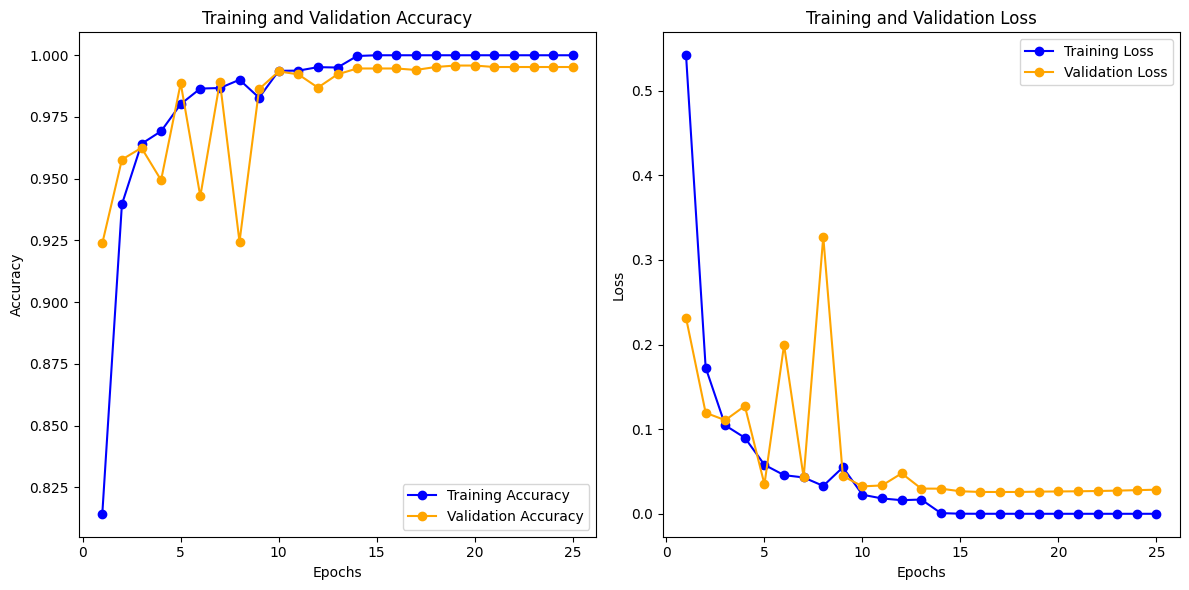

In [17]:
# Extracting metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Determine the number of epochs
epochs = len(acc)
epochs_range = range(1, epochs + 1)  # Create a range for the number of epochs

# Plotting
plt.figure(figsize=(12, 6))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [18]:
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    
    # Check if labels are already in the correct format
    if labels.ndim == 1:
        true = labels.numpy()
    else:
        true = np.argmax(labels.numpy(), axis=1)
    
    y_pred.extend(preds)
    y_true.extend(true)

# Compute precision, recall, and f1-score
print('\n', classification_report(y_true, y_pred, target_names=class_names))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)


1/1 [==============================] - 0s 38ms/step

                                             precision    recall  f1-score   support

                        Apple___Apple_scab       0.99      0.99      0.99       200
                         Apple___Black_rot       0.99      1.00      0.99       225
                  Apple___Cedar_apple_rust       1.00      1.00      1.00       198
                           Apple___healthy       1.00      0.98      0.99       196
                 Background_without_leaves       0.99      0.99      0.99       117
                         Grape___Black_rot       0.97      1.00      0.98       208
              Grape___Esca_(Black_Measles)       1.00      0.98      0.99       232
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       1.00      0.99      1.00       160
                           Grape___healthy       0.99      0.99      0.99       160

                                  accuracy                           0.99      1696
                    

Normalized confusion matrix


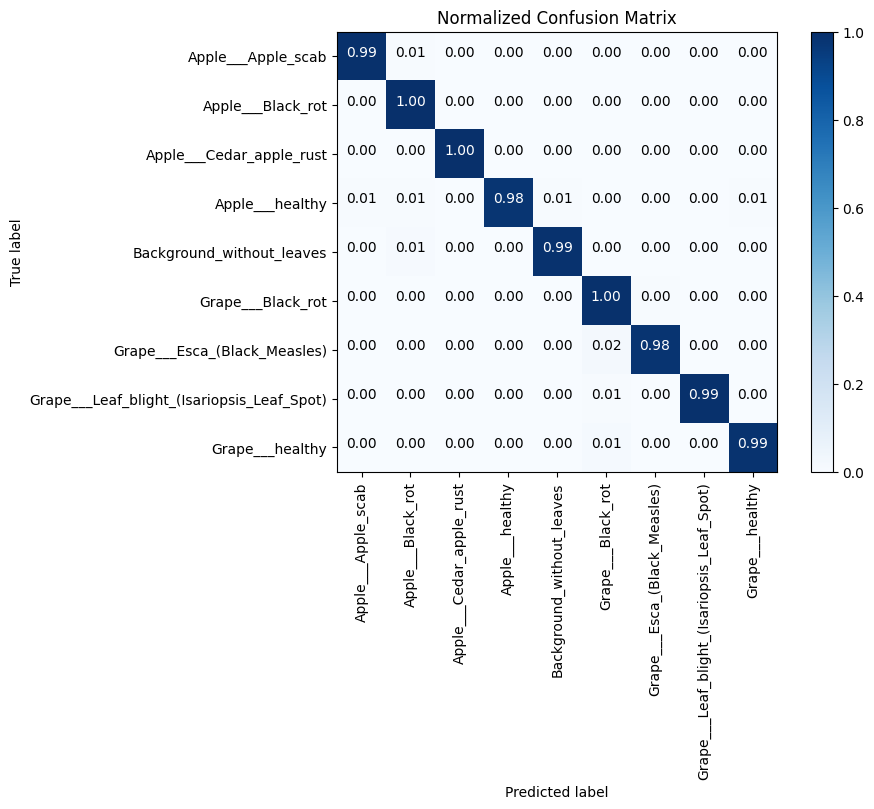

In [19]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Example usage
# First, compute the confusion matrix using sklearn.metrics.confusion_matrix
# from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Then, assuming 'class_names' is a list of your class names,
plot_confusion_matrix(conf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')


1/1 [==============================] - 0s 35ms/step


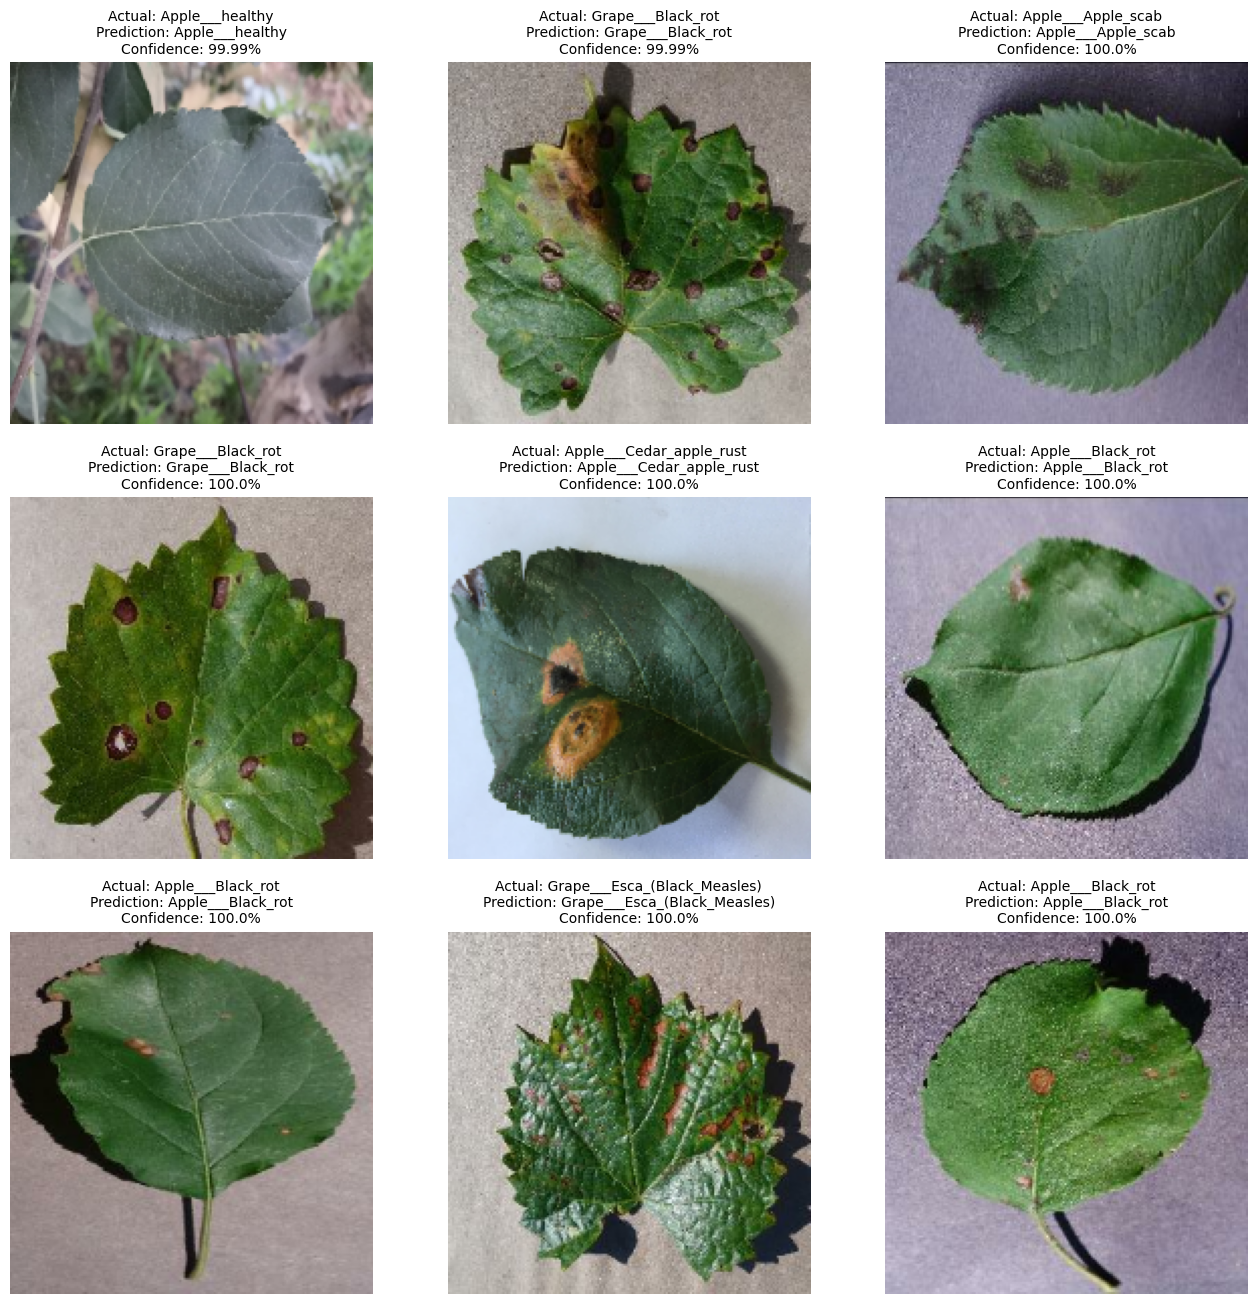

In [20]:
plt.figure(figsize=(16,16))
for batch_image, batch_label in test_ds.take(1):
    batch_prediction = model.predict(batch_image)  # Predict once per batch
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        plt.imshow(image)
        
        # Handling different label structures
        if len(batch_label[i].shape) == 0:  # Scalar label
            label_index = int(batch_label[i].numpy())
        elif len(batch_label[i].shape) == 1:  # One-hot encoded label or length-1 array
            label_index = np.argmax(batch_label[i].numpy())  # Use argmax for one-hot encoded labels
        else:
            raise ValueError("Unexpected label shape; check your dataset.")
        
        label = class_names[label_index]
        predicted_class = class_names[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        # Now with actual, prediction, and confidence on separate lines
        title_text = f'Actual: {label}\nPrediction: {predicted_class}\nConfidence: {confidence}%'
        plt.title(title_text, fontsize=10)  # Adjust fontsize as needed
        plt.axis('off')  # Optional: for a cleaner look
plt.show()

1/1 [==============================] - 0s 26ms/step


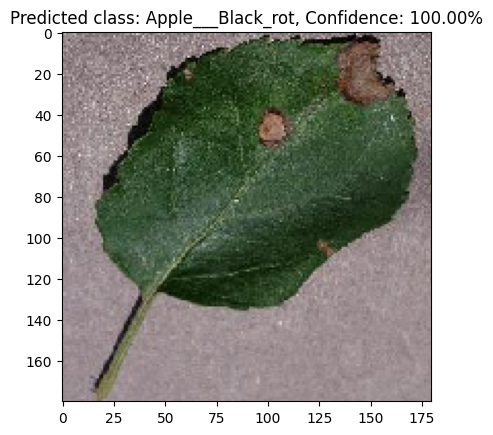

In [22]:
from tensorflow.keras.preprocessing import image
image_size = (180, 180)  # Adjust size as needed, without channel info for load_img

# Load and preprocess the image
img_path = "D:/Honours Project/test/apple_black_rot (2).jpg"
img = image.load_img(img_path, target_size=image_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Make predictions using the model
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
confidence = 100 * np.max(predictions[0])  # Directly use the max value from predictions

# Display the image and prediction
plt.imshow(img)
plt.title(f"Predicted class: {class_names[predicted_class_index]}, Confidence: {confidence:.2f}%")
plt.show()

In [23]:
model.save("D:/Honours Project/pretrained_models/sequential.keras")